<a href="https://colab.research.google.com/github/philocifer/AIE5/blob/main/10_Finetuning_Reasoning_Model/AI_Makerspace_Unsloth_GRPO_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AI Makerspace - Unsloth GRPO Training

In this notebook, we will use the work done by Unsloth to walk through a small scale sample of the DeepSeek-R1 process outlined in their paper.

This is not a direct 1-to-1, but it does outline the major innovations in the paper.

Let's dive in!

### What is the GRPO Training Process with RL?

1. Group Sampling: For a single prompt or state, the policy generates a batch of outputs (instead of just one). This produces a small “group” of possible actions or answers.

2. Reward Scoring: Each output is scored by a reward function, which reflects how good or desirable that output is for the task at hand.

3. Group-Based Advantage: The algorithm calculates each output’s “advantage” by comparing its reward to the average reward of the entire group. If the output’s reward is above average, it has a positive advantage (and vice versa).

4. Policy Update: The policy is adjusted to promote outputs with a positive advantage and discourage those with a negative advantage. A KL penalty term prevents the policy from changing too drastically.

5. Iterative Process: The updated policy is used again to generate new groups, score them, and update—repeating until the policy converges or meets performance goals.

This group-based approach removes the need for a separate value function (critic) and helps the policy quickly learn which outputs are relatively better within each sampled group.

# 🤝 BREAKOUT ROOM #1

> NOTE: A lot of the cells will take 1min. or more to run. This is expected!

### Overview of PEFT and LoRA:

Based on some awesome research [here](https://github.com/huggingface/peft), we can leverage techniques like PEFT and LoRA to train/fine-tune large models a lot more efficiently.

It can't be explained much better than the overview given in the above link:

```
Parameter-Efficient Fine-Tuning (PEFT) methods enable efficient adaptation of
pre-trained language models (PLMs) to various downstream applications without
fine-tuning all the model's parameters. Fine-tuning large-scale PLMs is often
prohibitively costly. In this regard, PEFT methods only fine-tune a small
number of (extra) model parameters, thereby greatly decreasing the
computational and storage costs. Recent State-of-the-Art PEFT techniques
achieve performance comparable to that of full fine-tuning.
```

### Installation

As you can see, we'll only need a few dependencies thanks to the collective hard work of the community!

In [1]:
%%capture
# Skip restarting message in Colab
import sys; modules = list(sys.modules.keys())
for x in modules: sys.modules.pop(x) if "PIL" in x or "google" in x else None

!pip install "unsloth==2025.2.4" vllm
!pip install --upgrade pillow
# If you are running this notebook on local, you need to install `diffusers` too
# !pip install diffusers
# Temporarily install a specific TRL nightly version
!pip install git+https://github.com/huggingface/trl.git@e95f9fb74a3c3647b86f251b7e230ec51c64b72b

### Unsloth

Use [`PatchFastRL`](https://github.com/unslothai/unsloth/blob/646ad2f141a3a0721d1ec9449cf9454b5612a84a/unsloth/models/rl.py#L44) before all functions to patch GRPO and other RL algorithms!

> NOTE: This patch overwrites the TRL `.generate` to be a bit more optimized. Classic Unsloth!

In [2]:
from unsloth import FastLanguageModel, PatchFastRL
PatchFastRL("GRPO", FastLanguageModel)

Unsloth: Patching Xformers to fix some performance issues.
🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
INFO 02-14 11:31:01 __init__.py:190] Automatically detected platform cuda.


## Task #1: Loading the Model

In the following task you will be expected to load the model from Hugging Face.

### Overview of Quantization:

Quantization is ultimately a simple concept with some very clever and tricky techniques that power it.

In today's notebook, we'll be exclusively focusing on the `bitsandbytes` quantization strategy which includes the idea of `k-bit` training.

Let's look at the QLoRA paper's definition of quantization:


```
Quantization is the process of discretizing an input from a representation that
holds more information to a representation with less information
```

Easy enough then!

Let's take a look at what that actually means.

### Block-wise k-bit Quantization

Ultimately, the QLoRA paper relies on a very specific form of quantization that relies on a few key ideas:

1. Model weights are mostly normally distributed
2. NF4 is a information-theoretically optimal data-type (this was later found to be [untrue](https://x.com/Tim_Dettmers/status/1668649436724199425?s=20), but NF4 is close to *empirically* optimal)


Let's think about quantization from a very high level - and use some oversimplifications to understand what's really happening under the hood.

In essence, we can think of quantization as placing a pin on the number line (our quantization constant) and then expressing a low-precision zero-centered size-64 block range around that pinned number. Exploiting the fact that our weights are normally distributed and that we scale them to be in the range [-1, 1], this lets use use our NF4 datatype to roughly optimally express our high precision weights in a low precision format. While we still do need *some* higher precision numbers - this process lets use represent many numbers in low precision for the cost of 1 number in high precision.

However, we can take it one step further - and we can actually quantize the range of quantization constants we wind up with as well! This winds up saving us ~0.373 bits per parameter.

#### Initializing LoRA Config

There's a lot to unpack here - so let's talk about the main parameters:

- `r`: is the "rank" of the two decomposed matrices we'll be using to represent our weight matrix. In reality, this is the dimension of the decomposed matrices.

Here is an exerpt from the paper to help provide context for the selected `r`

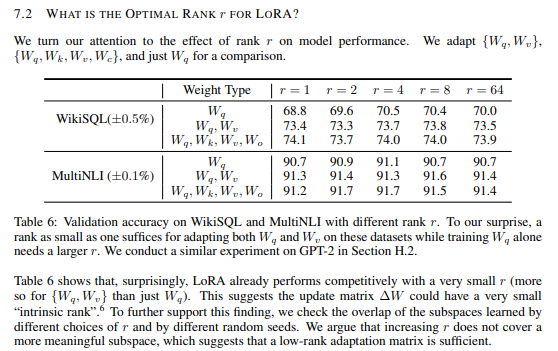


- `target_modules`: As LoRA can be applied to *any* weight matrix - we need to configure *which* module (weight matrix) it's being applied to. The LoRA paper suggests applying it to the Attention weights, but the QLoRA paper suggests we apply it to all Linear layers. Thus, we'll omit `target_module` from our hyper-parameters.


- `task_type`: This is a derived property. If you're using a causal model, this should be set to `CAUSAL_LM`. Please ensure this property is set based on your selected model.

Again, while this is the way we're leveraging LoRA in this notebook - it can be used in conjunction with many different models - and many different tasks. You can even use it for tasks like [token classification!](https://huggingface.co/docs/peft/task_guides/token-classification-lora)

Leveraging the work done in [QLoRA](https://arxiv.org/pdf/2305.14314.pdf) means we need to set some specific hyper-parameters for our [`quantization_config`](https://github.com/huggingface/transformers/blob/2fc33ebead50383f7707b17f0e2a178d86347d10/src/transformers/utils/quantization_config.py#L151).

- `load_in_4bit` - we'll want to set this to true so we can load and train our model on a single 16GB GPU.



In [3]:
from unsloth import is_bfloat16_supported
import torch
max_seq_length = 512 # Can increase for longer reasoning traces
lora_rank = 32 # Larger rank = smarter, but slower

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "meta-llama/meta-Llama-3.1-8B-Instruct",
    max_seq_length = max_seq_length,
    load_in_4bit = True, # False for LoRA 16bit
    fast_inference = True, # Enable vLLM fast inference
    max_lora_rank = lora_rank,
    gpu_memory_utilization = 0.6, # Reduce if out of memory
)

model = FastLanguageModel.get_peft_model(
    model,
    r = lora_rank, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = [
        "q_proj", "k_proj", "v_proj", "o_proj",
        "gate_proj", "up_proj", "down_proj",
    ], # Remove QKVO if out of memory
    lora_alpha = lora_rank,
    use_gradient_checkpointing = "unsloth", # Enable long context finetuning
    random_state = 3407,
)

==((====))==  Unsloth 2025.2.4: Fast Llama patching. Transformers: 4.48.2.
   \\   /|    GPU: NVIDIA A100-SXM4-40GB. Max memory: 39.557 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 8.0. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: vLLM loading unsloth/meta-llama-3.1-8b-instruct-bnb-4bit with actual GPU utilization = 59.37%
Unsloth: Your GPU has CUDA compute capability 8.0 with VRAM = 39.56 GB.
Unsloth: Using conservativeness = 1.0. Chunked prefill tokens = 512. Num Sequences = 288.
Unsloth: vLLM's KV Cache can use up to 17.31 GB. Also swap space = 6 GB.
INFO 02-14 11:31:29 config.py:542] This model supports multiple tasks: {'reward', 'score', 'generate', 'classify', 'embed'}. Defaulting to 'generate'.
Unsloth: vLLM Bitsandbytes config using kwarg

tokenizer_config.json:   0%|          | 0.00/55.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

INFO 02-14 11:31:35 cuda.py:230] Using Flash Attention backend.
INFO 02-14 11:31:35 model_runner.py:1110] Starting to load model unsloth/meta-llama-3.1-8b-instruct-bnb-4bit...
INFO 02-14 11:31:35 loader.py:1102] Loading weights with BitsAndBytes quantization.  May take a while ...
INFO 02-14 11:31:37 weight_utils.py:252] Using model weights format ['*.safetensors']


model.safetensors:   0%|          | 0.00/5.70G [00:00<?, ?B/s]

Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


INFO 02-14 11:31:56 model_runner.py:1115] Loading model weights took 5.3541 GB
INFO 02-14 11:31:56 punica_selector.py:18] Using PunicaWrapperGPU.
INFO 02-14 11:32:05 worker.py:267] Memory profiling takes 8.40 seconds
INFO 02-14 11:32:05 worker.py:267] the current vLLM instance can use total_gpu_memory (39.56GiB) x gpu_memory_utilization (0.59) = 23.49GiB
INFO 02-14 11:32:05 worker.py:267] model weights take 5.35GiB; non_torch_memory takes 0.09GiB; PyTorch activation peak memory takes 1.33GiB; the rest of the memory reserved for KV Cache is 16.71GiB.
INFO 02-14 11:32:06 executor_base.py:110] # CUDA blocks: 8553, # CPU blocks: 3072
INFO 02-14 11:32:06 executor_base.py:115] Maximum concurrency for 512 tokens per request: 267.28x
INFO 02-14 11:32:10 model_runner.py:1434] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI. If out-of-memory error o

Capturing CUDA graph shapes: 100%|██████████| 39/39 [00:52<00:00,  1.33s/it]

INFO 02-14 11:33:02 model_runner.py:1562] Graph capturing finished in 52 secs, took 0.89 GiB
INFO 02-14 11:33:02 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 65.69 seconds


tokenizer_config.json:   0%|          | 0.00/55.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

Unsloth 2025.2.4 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


In [4]:
print(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(128256, 4096, padding_idx=128004)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): lora.Linear(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Identity()
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=32, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): lora.Li

In [5]:
model.config

LlamaConfig {
  "_name_or_path": "unsloth/meta-llama-3.1-8b-instruct-bnb-4bit",
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "eos_token_id": 128009,
  "head_dim": 128,
  "hidden_act": "silu",
  "hidden_size": 4096,
  "initializer_range": 0.02,
  "intermediate_size": 14336,
  "max_position_embeddings": 131072,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 32,
  "num_key_value_heads": 8,
  "pad_token_id": 128004,
  "pretraining_tp": 1,
  "quantization_config": {
    "bnb_4bit_compute_dtype": "bfloat16",
    "bnb_4bit_quant_type": "nf4",
    "bnb_4bit_use_double_quant": true,
    "llm_int8_enable_fp32_cpu_offload": false,
    "llm_int8_has_fp16_weight": false,
    "llm_int8_skip_modules": null,
    "llm_int8_threshold": 6.0,
    "load_in_4bit": true,
    "load_in_8bit": false,
    "quant_method": "bitsandbytes"
  },
  "rms_norm_eps": 1e-05,
  "rope_sca

#### ❓Question #1:

What exactly is happening in the double quantization step?

> NOTE: You can use the paper provided to find the answer!

#### ❓Question #2:

![image](https://i.imgur.com/N8y2crZ.png)

Label the image with the appropriate layer from `meta-llama/Llama-3.1-8B-Instruct`'s architecture.

- EXAMPLE - Layer Norm:
  - `(input_layernorm): LlamaRMSNorm()`
  - `(post_attention_layernorm): LlamaRMSNorm()`
  - `(norm): LlamaRMSNorm()`
- Feed Forward:
- Masked Multi Self-Attention:
- Text & Position Embed:
- Text Prediction:

#### ❓Question #3:

What modules (or groupings of layers) did we apply LoRA too - and how can we tell from the model summary?

# 🤝 BREAKOUT ROOM #2

### Data Preparation

You'll notice a peculiarity here - our dataset is just...inputs and outputs! (specifically from the GSM8K data).

But wait, we said this was different from SFT - but this is seemingly just SFT all over again!

Well, we still need questions and answers to verify that we're learning *something* productive - but importantly, we are not leveraging a specific human preference reward model, or process reward model to bake our responses into the model - we just need a way to verify if an answer provided by our model was correct or incorrect. A way, to *reward* correct generations!

For now, let's examine what our input data looks like.

> NOTE: Unsloth directly leveraged the work that [@willccbb](https://gist.github.com/willccbb/4676755236bb08cab5f4e54a0475d6fb) did, for data prep and all reward functions.

In [6]:
import re
from datasets import load_dataset, Dataset

# This string defines the instructions for formatting responses.
# Responses should include two parts: reasoning and answer, each wrapped in XML-like tags.
SYSTEM_PROMPT = """
Respond in the following format:
<reasoning>
...
</reasoning>
<answer>
...
</answer>
"""

# This template provides a way to format the response with placeholders for reasoning and answer.
XML_COT_FORMAT = """\
<reasoning>
{reasoning}
</reasoning>
<answer>
{answer}
</answer>
"""

def extract_xml_answer(text: str) -> str:
    """
    Extracts and returns the text between the <answer> and </answer> tags.

    Steps:
    1. Splits the input text at the <answer> tag and takes the last part.
    2. Splits the result at the </answer> tag.
    3. Strips any extra whitespace and returns the cleaned answer.
    """
    answer = text.split("<answer>")[-1]
    answer = answer.split("</answer>")[0]
    return answer.strip()

def extract_hash_answer(text: str) -> str | None:
    """
    Looks for the marker '####' in the input text.

    If found:
    - Splits the text on '####' and returns the portion after the marker, stripped of whitespace.
    If not found:
    - Returns None.
    """
    if "####" not in text:
        return None
    return text.split("####")[1].strip()

# uncomment middle messages for 1-shot prompting
def get_gsm8k_questions(split = "train") -> Dataset:
    """
    Loads the GSM8K dataset (grade school math problems) and processes each item.

    For each problem in the dataset:
    1. Creates a prompt with two messages:
       - A system message containing the response formatting instructions.
       - A user message containing the question.
    2. Extracts the answer using the 'extract_hash_answer' function.

    Returns:
        The processed dataset with each entry containing the formatted prompt and extracted answer.
    """
    data = load_dataset('openai/gsm8k', 'main')[split] # type: ignore
    data = data.map(lambda x: { # type: ignore
        'prompt': [
            {'role': 'system', 'content': SYSTEM_PROMPT},
            {'role': 'user', 'content': x['question']}
        ],
        'answer': extract_hash_answer(x['answer'])
    }) # type: ignore
    return data # type: ignore

dataset = get_gsm8k_questions()

README.md:   0%|          | 0.00/7.94k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/2.31M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/419k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7473 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1319 [00:00<?, ? examples/s]

Map:   0%|          | 0/7473 [00:00<?, ? examples/s]

As you can see in this data, there is no specific information about preference, or "how to reason", or anything close to it. It's simply the question and the answer.

This is the core idea behind this style of training - we're not going to give the model *how* to think as an example - we're simply going to let it play in a sandbox defined by the question and answer.

> NOTE: This is not the case for DeepSeek-R1, where there is a *very small* amount of SFT that occurs (called the "cold-start") to "prime" the model for the subsequent RL stage of training.

In [7]:
dataset[0]

{'question': 'Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?',
 'answer': '72',
 'prompt': [{'content': '\nRespond in the following format:\n<reasoning>\n...\n</reasoning>\n<answer>\n...\n</answer>\n',
   'role': 'system'},
  {'content': 'Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?',
   'role': 'user'}]}

Now we get to the *magic* of the approach - a collection of reward models.

Notice that we have a number of different "checks" we do - these come together as expressed in the following diagram:

![image](https://i.imgur.com/7Dp0qdt.png)

What this means, essentially, is that we use a suite of reward functions to determine if our model is learning "how we want", as opposed to giving it examples that show it how we want it to learn.

These reward functions are totally customizable - and allow users to effectively steer how and what the model is incentivized to "get good at".

In [8]:
# Reward functions
def correctness_reward_func(prompts, completions, answer, **kwargs) -> list[float]:
    """
    This function evaluates the correctness of the model's response.

    Steps:
    - It extracts the content of the first message from each completion.
    - It then extracts the answer from the XML-formatted response using the extract_xml_answer function.
    - For debugging, it prints the original question, the expected answer, the raw response, and the extracted answer.
    - Finally, it compares the extracted response to the expected answer and assigns a reward of 2.0 if they are equal, otherwise 0.0.
    """
    responses = [completion[0]['content'] for completion in completions]
    q = prompts[0][-1]['content']
    extracted_responses = [extract_xml_answer(r) for r in responses]
    print('-'*20, f"Question:\n{q}", f"\nAnswer:\n{answer[0]}", f"\nResponse:\n{responses[0]}", f"\nExtracted:\n{extracted_responses[0]}")
    return [2.0 if r == a else 0.0 for r, a in zip(extracted_responses, answer)]

def int_reward_func(completions, **kwargs) -> list[float]:
    """
    This function rewards responses that are purely numeric.

    Steps:
    - It extracts the content of the first message from each completion.
    - It extracts the answer from the XML-formatted response.
    - It checks if the extracted answer is a digit (i.e., a numeric string) and returns a reward of 0.5 if it is, otherwise 0.0.
    """
    responses = [completion[0]['content'] for completion in completions]
    extracted_responses = [extract_xml_answer(r) for r in responses]
    return [0.5 if r.isdigit() else 0.0 for r in extracted_responses]

def strict_format_reward_func(completions, **kwargs) -> list[float]:
    """
    This function rewards responses that exactly follow a strict XML format.

    Steps:
    - It uses a regular expression pattern that enforces the precise structure:
      The response must start with <reasoning> on its own line, followed by some text,
      then </reasoning> on its own line, then <answer> on its own line, some text,
      and finally </answer> on its own line, with no extra content before or after.
    - It returns a reward of 0.5 if the response exactly matches this pattern, otherwise 0.0.
    """
    pattern = r"^<reasoning>\n.*?\n</reasoning>\n<answer>\n.*?\n</answer>\n$"
    responses = [completion[0]["content"] for completion in completions]
    matches = [re.match(pattern, r) for r in responses]
    return [0.5 if match else 0.0 for match in matches]

def soft_format_reward_func(completions, **kwargs) -> list[float]:
    """
    This function rewards responses that generally follow the expected XML format.

    Steps:
    - It uses a more relaxed regular expression pattern that checks for the presence of <reasoning> and </reasoning>
      followed by <answer> and </answer> somewhere in the text.
    - It returns a reward of 0.5 if the pattern is found, otherwise 0.0.
    """
    pattern = r"<reasoning>.*?</reasoning>\s*<answer>.*?</answer>"
    responses = [completion[0]["content"] for completion in completions]
    matches = [re.match(pattern, r) for r in responses]
    return [0.5 if match else 0.0 for match in matches]

def count_xml(text) -> float:
    """
    This helper function calculates a reward score based on the presence and exact count
    of specific XML formatting markers in the text.

    Steps:
    - It checks if the text contains exactly one occurrence of each of the tags with newlines:
      "<reasoning>\n", "\n</reasoning>\n", "\n<answer>\n", and "\n</answer>".
    - It adds 0.125 to the count for each correctly placed tag.
    - For the <answer> and </answer> tags, it subtracts a small penalty based on the length of the text
      following the closing tags.
    - Returns the total score.
    """
    count = 0.0
    if text.count("<reasoning>\n") == 1:
        count += 0.125
    if text.count("\n</reasoning>\n") == 1:
        count += 0.125
    if text.count("\n<answer>\n") == 1:
        count += 0.125
        count -= len(text.split("\n</answer>\n")[-1])*0.001
    if text.count("\n</answer>") == 1:
        count += 0.125
        count -= (len(text.split("\n</answer>")[-1]) - 1)*0.001
    return count

def xmlcount_reward_func(completions, **kwargs) -> list[float]:
    """
    This function applies the count_xml helper function to each completion.

    Steps:
    - It extracts the content of the first message from each completion.
    - It computes a reward score for each response by counting the XML formatting elements using count_xml.
    - Returns a list of reward scores.
    """
    contents = [completion[0]["content"] for completion in completions]
    return [count_xml(c) for c in contents]

### Train the model

All that is left to do, now that we have our:

1. Training examples
2. Reward Functions

Is to train our model!

We'll start with setting a number of hyper-parameters.

> NOTE: These hyper-parameters are based around the free-tier Colab T4 instance, you can modify them to "right size" to your hardware.

### GPROConfig

First and foremost - we have a number of typical hyper-parameters (as always).

You'll also notice a distinct *lack* of GRPO hyper-parameters being used in this implementation - we'll stick with the defaults to keep this notebook manageable, but you're welcome to dive deep into TRL and play around to see what works best for your use-case.

> NOTE: If you wish to walk away with the classic "RL" image of "line going up to the right", you can remove the `report_to = "none"` from the following config.This will require you to have a Weights and Biases API key - which you can get by following [this](https://docs.wandb.ai/quickstart/) process.

In [9]:
from trl import GRPOConfig, GRPOTrainer
training_args = GRPOConfig(
    use_vllm = True, # use vLLM for fast inference!
    learning_rate = 5e-6,
    adam_beta1 = 0.9,
    adam_beta2 = 0.99,
    weight_decay = 0.1,
    warmup_ratio = 0.1,
    lr_scheduler_type = "cosine",
    optim = "paged_adamw_8bit",
    logging_steps = 1,
    bf16 = is_bfloat16_supported(),
    fp16 = not is_bfloat16_supported(),
    per_device_train_batch_size = 1,
    gradient_accumulation_steps = 1, # Increase to 4 for smoother training
    num_generations = 3, # Decrease if out of memory
    max_prompt_length = 256,
    max_completion_length = 200,
    # num_train_epochs = 1, # Set to 1 for a full training run
    max_steps = 250,
    save_steps = 250,
    max_grad_norm = 0.1,
    report_to = "none", # Can use Weights & Biases
    output_dir = "outputs",
)

torch.distributed process group is initialized, but parallel_mode != ParallelMode.DISTRIBUTED. In order to use Torch DDP, launch your script with `python -m torch.distributed.launch


#### ❓Question #4:

Describe what the following parameters are doing:

- `warmup_ratio`
- `learning_rate`
- `lr_scheduler_type`

> NOTE: Feel free to consult the [documentation](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments) or other resources!

Finally, we can run our trainer!

The basic idea in this RL focused approach is that, instead of watching loss go down, we want to watch reward *go up!*.

> NOTE: The training has a kind of "Aha!" moment, as it's been described, whereby the reward goes from ~0 and then suddenly begins increasing. This is expected behaviour - but you may not see changes in the reward column (the combined output of our above define reward functions) until you get past the 100th-150th step.

In [10]:
trainer = GRPOTrainer(
    model = model,
    processing_class = tokenizer,
    reward_funcs = [
        xmlcount_reward_func,
        soft_format_reward_func,
        strict_format_reward_func,
        int_reward_func,
        correctness_reward_func,
    ],
    args = training_args,
    train_dataset = dataset,
)
trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 7,473 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 1
\        /    Total batch size = 1 | Total steps = 250
 "-____-"     Number of trainable parameters = 83,886,080


-------------------- Question:
Ahmed and Emily are having a contest to see who can get the best grade in the class. There have been 9 assignments and Ahmed has a 91 in the class. Emily has a 92. The final assignment is worth the same amount as all the other assignments. Emily got a 90 on the final assignment. What is the minimum grade Ahmed needs to get to beat Emily if all grades are whole numbers? 
Answer:
100 
Response:
</reasoning>
Assuming Ahmed's current score of 91 represents the sum of the grades in the first 8 assignments, and the grade in the final assignment, we can denote Ahmed's score in the final assignment as 'x' when it's worth the same as other assignments. Since there are 9 assignments in total and each one is worth the same, the sum of Ahmed's scores can be expressed as 8.91 + x.

</reasoning>
<answer>
To determine the minimum grade Ahmed needs, we first calculate Emily's current score. Since Emily has a 92 overall and her score on the final assignment is 90, and the

Step,Training Loss,reward,reward_std,completion_length,kl
1,0.000000,0.085333,0.073962,200.000000,0.000000
2,0.000000,0.042000,0.072746,168.000000,0.000000
3,0.000000,-0.150000,0.155792,125.000000,0.000303
4,0.000000,0.890667,1.396374,174.333344,0.000266
5,0.000000,0.000000,0.000000,200.000000,0.000223
6,0.000000,0.000000,0.000000,143.666672,0.000252
7,0.000000,0.146333,0.253457,146.666672,0.000456
8,0.000000,2.406667,0.168634,142.000000,0.000301
9,0.000000,0.000000,0.000000,167.000000,0.000215
10,0.000000,0.070667,0.122398,127.333336,0.000448


-------------------- Question:
The gauge on a water tank shows that the tank is 1/3 full of water. To fill the tank, 16 gallons of water are added. How many gallons of water does the tank hold when full? 
Answer:
24 
Response:
Let's break it down step by step:

We know that the water in the tank is 1/3 full initially. When 16 gallons of water are added, the tank is full.

Let the total capacity of the tank be x gallons.

Since the initial water level is 1/3, the amount of water in the tank initially is 1/3 * x.

After adding 16 gallons, the total water in the tank is x. We can set up an equation:

(1/3)x + 16 = x

To solve for x, we need to isolate the variable. Subtract (1/3)x from both sides:

16 = x - (1/3)x

16 = (2/3)x

Now, multiply both sides by the reciprocal of (2/3), which is (3/2), to solve for x:

16 * (3/2) = x

24 = x

The tank holds 24 gallons when full. 
Extracted:
Let's break it down step by step:

We know that the water in the tank is 1/3 full initially. When 16 gallo

Step,Training Loss,reward,reward_std,completion_length,kl
1,0.000000,0.085333,0.073962,200.000000,0.000000
2,0.000000,0.042000,0.072746,168.000000,0.000000
3,0.000000,-0.150000,0.155792,125.000000,0.000303
4,0.000000,0.890667,1.396374,174.333344,0.000266
5,0.000000,0.000000,0.000000,200.000000,0.000223
6,0.000000,0.000000,0.000000,143.666672,0.000252
7,0.000000,0.146333,0.253457,146.666672,0.000456
8,0.000000,2.406667,0.168634,142.000000,0.000301
9,0.000000,0.000000,0.000000,167.000000,0.000215
10,0.000000,0.070667,0.122398,127.333336,0.000448


-------------------- Question:
Jason is tired of the neighborhood animals raiding his trash. He pepper-sprays some raccoons and 6 times as many squirrels. If he pepper-sprays 84 animals total, how many raccoons does he pepper-spray? 
Answer:
12 
Response:
Let's break this problem down. Let R be the number of raccoons pepper-sprayed. Since Jason pepper-sprays 6 times as many squirrels as raccoons, the number of squirrels will be 6R.

The total number of animals is the sum of raccoons and squirrels, which is given as 84. So we can set up the equation: R + 6R = 84

Combine like terms: 7R = 84

Divide both sides by 7: R = 12

So Jason pepper-sprays 12 raccoons. 
Extracted:
Let's break this problem down. Let R be the number of raccoons pepper-sprayed. Since Jason pepper-sprays 6 times as many squirrels as raccoons, the number of squirrels will be 6R.

The total number of animals is the sum of raccoons and squirrels, which is given as 84. So we can set up the equation: R + 6R = 84

Combine l

TrainOutput(global_step=250, training_loss=0.00019859103783346655, metrics={'train_runtime': 2355.5712, 'train_samples_per_second': 0.106, 'train_steps_per_second': 0.106, 'total_flos': 0.0, 'train_loss': 0.00019859103783346655})

You can see our Reward Curve here:

![image](https://i.imgur.com/Gv7HOzJ.png)

As you can see, this is a quite noisey training run at this scale on this hardware - but the general pattern of "up to the right" is clearly visible in our rewards over time!

<a name="Inference"></a>
### Inference
Now let's try the model we just trained! First, let's first try the model without any GRPO trained:

In [11]:
text = tokenizer.apply_chat_template([
    {"role" : "user", "content" : "Calculate pi!"},
], tokenize = False, add_generation_prompt = True)

from vllm import SamplingParams
sampling_params = SamplingParams(
    temperature = 0.8,
    top_p = 0.95,
    max_tokens = 1024,
)
output = model.fast_generate(
    [text],
    sampling_params = sampling_params,
    lora_request = None,
)[0].outputs[0].text

output

Processed prompts: 100%|██████████| 1/1 [00:06<00:00,  6.38s/it, est. speed input: 6.12 toks/s, output: 74.36 toks/s]


'Calculating pi is a complex mathematical problem that has been studied for centuries. There are various methods to calculate pi, ranging from simple geometric constructions to advanced numerical algorithms.\n\nHere\'s a simple example of how to calculate pi using a basic algorithm:\n\n**Method 1: Bailey-Borwein-Plouffe formula (BBP formula)**\n\nThe BBP formula is a spigot algorithm for computing the nth binary digit of pi, discovered by Simon Plouffe in 1995. It is a non-recursive formula that uses a summation of fractions to compute the nth digit.\n\nThe formula is:\n\npi = \\sum_{k=0}^{\\infty} \\frac{1}{16^k} \\left( \\frac{4}{8k+1} - \\frac{2}{8k+4} - \\frac{1}{8k+5} - \\frac{1}{8k+6} \\right)\n\nHere\'s a simple Python implementation of the BBP formula to calculate the first 50 digits of pi:\n\n```python\ndef calculate_pi(n):\n    pi = 0.0\n    for k in range(n):\n        pi += 1/(16**k) * (4/(8*k+1) - 2/(8*k+4) - 1/(8*k+5) - 1/(8*k+6))\n    return pi\n\nprint("Pi:", round(calcu

And now with the LoRA we just trained with GRPO - we first save the LoRA first!

In [12]:
model.save_lora("grpo_saved_lora")

Now we load the LoRA and test:

In [13]:
text = tokenizer.apply_chat_template([
    {"role" : "system", "content" : SYSTEM_PROMPT},
    {"role" : "user", "content" : "Calculate pi"},
], tokenize = False, add_generation_prompt = True)

from vllm import SamplingParams
sampling_params = SamplingParams(
    temperature = 0.8,
    top_p = 0.95,
    max_tokens = 1024,
)
output = model.fast_generate(
    text,
    sampling_params = sampling_params,
    lora_request = model.load_lora("grpo_saved_lora"),
)[0].outputs[0].text

output

Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.62s/it, est. speed input: 12.99 toks/s, output: 66.89 toks/s]


'<reasoning>\nOne way to calculate pi is by using the infinite series expansion of its mathematical formula. The formula for pi (π) is given by the infinite series:\n\nπ = 4 \\* (1 - 1/3 + 1/5 - 1/7 + 1/9 - ...)\n\nThis is an alternating series where the terms alternate between positive and negative. The series is also known as the Leibniz formula for pi.\n\nTo calculate the value of pi, we can use this formula and sum up the terms of the series to a certain number of iterations.\n\nThe more iterations we perform, the more accurate our approximation of pi will be.\n</reasoning>\n\n<answer>\nTo calculate pi to 10 decimal places, we can use the following Python code:\n\n```python\nimport math\n\ndef calculate_pi(n):\n    pi = 0.0\n    for i in range(n):\n        pi += ((-1)**i) / (2*i + 1)\n    return 4 * pi\n\npi_value = round(calculate_pi(10000), 10)\nprint(pi_value)\n```\n\nWhen you run this code, it will output the value of pi to 10 decimal places.\n\nAlternatively, you can use a pre

And in classic fashion - the "reasoning model" is better at the task than the non-reasoning variant.

Check out that calculation of pi:

![image](https://i.imgur.com/6iAFJj7.png)

All this inside of an hour in a Colab instance - this is the power of Open Source!